# GPU Bench-marking with Image Classification

Link to Youtube tutorial video: https://www.youtube.com/watch?v=YmDaqXMIoeY&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=17


In [37]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# List down the physical devices which are available for TensorFlow to use

In [38]:
tf.config.experimental.list_physical_devices()

# Ensure the modules are in the version mentioned below, so that GPU only will be listed by the list_physical_devices() above.

# CUDA need to be installed in order to use GPU

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [39]:
tf.test.is_built_with_cuda()

False

# Load the dataset

In [40]:
# Load the CIFAR10 dataset from Keras in TensorFlow into train and test sets respectively
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print('The number of samples in the train set: ' + str(X_train.shape[0]) +
      '\nThe dimension of each sample (image) in the train set: ' + str(X_train.shape[1]) + ' x ' + str(X_train.shape[2]) +
      '\nThe colour channel of each sample (image) in the train set: ' + str(X_train.shape[3]))

The number of samples in the train set: 50000
The dimension of each sample (image) in the train set: 32 x 32
The colour channel of each sample (image) in the train set: 3


In [41]:
# The 1st image/sample in the train set. This shows the pixel values across all rows (32 rows) but at the 1st column of the image. Each pixel value consists of 3 elements in 1D array.
print('For the 1st image in the train set (32 rows pixels at 1st column of the image):\n', X_train[0][0])
print('\nThe dimension of X_train: ', X_train.shape)

# The first 5 ground truths in the train set
print('\nThe first 5 ground truths in the train set', Y_train[0:5])
print('\nThe dimension of Y_train: ', Y_train.shape)

For the 1st image in the train set (32 rows pixels at 1st column of the image):
 [[ 59  62  63]
 [ 43  46  45]
 [ 50  48  43]
 [ 68  54  42]
 [ 98  73  52]
 [119  91  63]
 [139 107  75]
 [145 110  80]
 [149 117  89]
 [149 120  93]
 [131 103  77]
 [125  99  76]
 [142 115  91]
 [144 112  86]
 [137 105  79]
 [129  97  71]
 [137 106  79]
 [134 106  76]
 [124  97  64]
 [139 113  78]
 [139 112  75]
 [133 105  69]
 [136 105  74]
 [139 108  77]
 [152 120  89]
 [163 131 100]
 [168 136 108]
 [159 129 102]
 [158 130 104]
 [158 132 108]
 [152 125 102]
 [148 124 103]]

The dimension of X_train:  (50000, 32, 32, 3)

The first 5 ground truths in the train set [[6]
 [9]
 [9]
 [4]
 [1]]

The dimension of Y_train:  (50000, 1)


# Data Visualization

In [42]:
# Self-defined function to visualize an image(sample) in the train set
def plot_sample(index):
    plt.figure(figsize=(10,1)) # Define the shape of the figure window
    plt.imshow(X_train[index]) # Plot/visualize the image

The class name index of the image:  8
The class name of the image:  ship


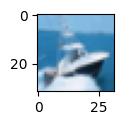

In [43]:
# Define the class names of the dataset
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Check if the class names are defined correctly according to their sequence:
plot_sample(8)
# Y_train[0] provides the index that corresponding to a class name in 1D array. Y_train[0][0] provides the index that corresponding to a class name as number format (not 1D array)
print('The class name index of the image: ', Y_train[8][0])
print('The class name of the image: ', classes[Y_train[8][0]]) 

# Data Preprocessing

## Data (Features) Scaling

1) Scale each pixel value (feature, this means each image (32x32 dimension in 3 color channels) has 32 x 32 x 3 = 3072 features, and so the dataset is) into range between 0 to 1, by dividing each image by 255 (use the concept of matrix). So that the model can perform better
2) The each element of pixel values in RGB colour space ranged from 0 to 255. EG: [R, G, B] = [255, 0, 29] 

In [46]:
# Scale the features of the dataset
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

print('The first sample in X_train_scaled:\n', X_train_scaled[0])

The first sample in X_train_scaled:
 [[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]


## Convert the ground truths (categorical labels) of the dataset into one-hot-encoding form
1) We don't scale the ground truths (Y_train & Y_test) of the dataset because each value represents a class name. Since the ground truths are class name (categorical label), we convert them into one-hot-encoding form (to eliminate the effect of ranking that will degrade the model performance)

The class name of the image:  cat
The class name index of the image:  3
The one-hot-encoding representation of the class name index of the same image:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


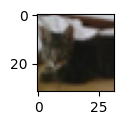

In [58]:
# Convert the ground truths in train set into one-hot-encoding form
Y_train_categorical = keras.utils.to_categorical(
    Y_train, num_classes = 10 # num_class = number of different class names of the dataset
)

# Convert the ground truths in test set into one-hot-encoding form
Y_test_categorical = keras.utils.to_categorical(
    Y_test, num_classes = 10 # num_class = number of different class names of the dataset
)

# Comparison of class name representation between index form and one-hot-encoding form 
'''
The index 3 is actually corresponding to the class name located at 4th sequence. Hence, in its one-hot-encoded representation, only the 4th value is 1.
'''
plot_sample(9)
print('The class name of the image: ', classes[Y_train[9][0]]) 
print('The class name index of the image: ', Y_train[9][0])
print('The one-hot-encoding representation of the class name index of the same image: ', Y_train_categorical[9])

# Develop a neural network [Artificial Neural Network (ANN), not CNN]

1) The more the hidden layers the neural network have, the better the performance of the neural network. Because the feature can be extracted better when it have more layers.
2) Use sparse_categorical_crossentropy as cost function, if the ground truths you are using are discrete value (EG: information in Y_train)
2) Use categorical_crossentropy as cost function, if the ground truths you are using are in the one-hot-encoding representation (EG: information in Y_train_categorical)

In [62]:
# Develop the structure of the neural network (model)
model = keras.Sequential([
    # The flatten layer, that flattens each image of 32x32 dimension with 3 color channels into 1D array. Means each flatten image consists of 32*32*3=3072 features in 1D array before being input to the neural network.
    keras.layers.Flatten(input_shape=(32,32,3)),
    # The hidden layer (the 2nd layer/element of the neural network), which consists of 3000 neurons. ReLU activation function is preferred for hidden layer.
    keras.layers.Dense(3000, activation='relu'),
    # The hidden layer (the 3rdd layer/element of the neural network), which consists of 1000 neurons. ReLU activation function is preferred for hidden layer.
    keras.layers.Dense(1000, activation='relu'),
    # The output layer, which consists of 10 output neurons/units to classify all possible 10 class names. Sigmoid activation function is preferred for output layer.
    keras.layers.Dense(10, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='SGD', # stochastic gradient descent
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
model.fit(X_train_scaled, Y_train_categorical, epochs=50)

c:\Users\weiyo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.3037 - loss: 1.9286
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.4185 - loss: 1.6427
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.4510 - loss: 1.5569
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.4738 - loss: 1.4879
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.4908 - loss: 1.4396
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.5119 - loss: 1.3847
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.5253 - loss: 1.3498
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 59s 38ms/step - accuracy: 0.5352 - loss: 1.3158
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.5476 - loss: 1.2888
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.5658 - loss: 1.2458
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - accuracy: 0.5733 - loss: 1.2169
Epoch 12

In [67]:
# Use the model to make prediction on the 2nd sample in test set. argmax() is used to determine the index of the maximum score out of 10 scores provided by the 10 output neurons for a sample respectively
print('The prediection result over the sample: ', classes[np.argmax(model.predict(X_test_scaled)[1])])

# Show the ground truth of the same sample
print('The ground truth of the same sample: ', classes[Y_test[1][0]])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
The prediection result over the sample:  ship
The ground truth of the same sample:  ship


In [68]:
# Get the accuracy of the model
model.evaluate(X_test_scaled, Y_test_categorical)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5639 - loss: 1.6118


[1.604327917098999, 0.5590999722480774]

# Compare the performance of training a neural network by using CPU vs GPU

In [70]:
def get_model():
    # Develop the structure of the neural network (model)
    model = keras.Sequential([
        # The flatten layer, that flattens each image of 32x32 dimension with 3 color channels into 1D array. Means each flatten image consists of 32*32*3=3072 features in 1D array before being input to the neural network.
        keras.layers.Flatten(input_shape=(32,32,3)),
        # The hidden layer (the 2nd layer/element of the neural network), which consists of 3000 neurons. ReLU activation function is preferred for hidden layer.
        keras.layers.Dense(3000, activation='relu'),
        # The hidden layer (the 3rdd layer/element of the neural network), which consists of 1000 neurons. ReLU activation function is preferred for hidden layer.
        keras.layers.Dense(1000, activation='relu'),
        # The output layer, which consists of 10 output neurons/units to classify all possible 10 class names. Sigmoid activation function is preferred for output layer.
        keras.layers.Dense(10, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer='SGD', # stochastic gradient descent
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Measure the neural network training time using CPU

In [71]:
%%timeit -n1 -r1 # it will measure the time it took to execute this single cell
with tf.device('/CPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, Y_train_categorical, epochs=1)

c:\Users\weiyo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.3019 - loss: 1.9344
1min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Measure the neural network training time using GPU

In [72]:
%%timeit -n1 -r1 # it will measure the time it took to execute this single cell
with tf.device('/GPU:0'):
    cpu_model = get_model()
    cpu_model.fit(X_train_scaled, Y_train_categorical, epochs=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.3087 - loss: 1.9270
1min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
